In [280]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup
import time
import random
import re
import json
import traceback
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt



In [ ]:
user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89.0) Gecko/20100101 Firefox/89.0',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15'

]

In [ ]:
def get_article_data(url):
    headers = {'User-Agent': random.choice(user_agents)}
    
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        
        title_h1 = soup.find(id="firstHeading")
        title = title_h1.text if title_h1 else 'N/A'

        lang_div = soup.find(id="p-lang-btn-checkbox")
        match = re.search(r"\d+", lang_div.get("aria-label")) if lang_div else None
        num_languages = int(match.group()) if match else '0'
        
        title_url_encoded = title.replace(' ', '_')
        title_url_encoded = requests.utils.quote(title_url_encoded) 
        pageviews_url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{title_url_encoded}/monthly/2015070100/2023050100"
        pageviews_response = requests.get(pageviews_url, {'User-Agent': random.choice(user_agents)})
        pageviews_data = json.loads(pageviews_response.text) if pageviews_response.status_code == 200 else None
        num_views = sum(item['views'] for item in pageviews_data['items']) if pageviews_data and 'items' in pageviews_data else 'N/A'

        xtools_url = f"https://xtools.wmcloud.org/articleinfo/en.wikipedia.org/{title_url_encoded}"
        xtools_response = requests.get(xtools_url, headers=headers)
        if xtools_response.status_code == 200:
            xtools_soup = BeautifulSoup(xtools_response.content, 'html.parser')

            links_to = xtools_soup.select_one("#general-stats > div > div.col-lg-4.col-lg-offset-1.stat-list.clearfix > table > tbody > tr:nth-child(2) > td:nth-child(2) > a")
            num_links = int(links_to.text.replace(',', '')) if links_to else 'N/A'

            links_from = xtools_soup.select_one("#general-stats > div > div.col-lg-4.col-lg-offset-1.stat-list.clearfix > table > tbody > tr:nth-child(4) > td:nth-child(2)")
            num_links_from = int(links_from.text.replace(',', '')) if links_from else 'N/A'
            
            ext_links = xtools_soup.select_one("#general-stats > div > div.col-lg-4.col-lg-offset-1.stat-list.clearfix > table > tbody > tr:nth-child(5) > td:nth-child(2)")
            num_ext_links = int(ext_links.text.replace(',', '')) if ext_links else 'N/A'
            
            num_edits = xtools_soup.select_one("#general-stats > div > div.col-lg-5.col-lg-offset-1.stat-list.clearfix > table > tbody > tr:nth-child(4) > td:nth-child(2)")
            num_edits = int(num_edits.text.strip().replace(',', '')) if num_edits else 'N/A'

            num_editors = xtools_soup.select_one("#general-stats > div > div.col-lg-5.col-lg-offset-1.stat-list.clearfix > table > tbody > tr:nth-child(5) > td:nth-child(2)")
            num_editors = int(num_editors.text.replace(',', '')) if num_editors else 'N/A'
            
            characters = xtools_soup.select_one("#general-stats > div > div.col-lg-3.stat-list.clearfix > table > tbody > tr:nth-child(3) > td:nth-child(2)")
            num_characters = int(characters.text.replace(',', '')) if characters else 'N/A'

            words = xtools_soup.select_one("#general-stats > div > div.col-lg-3.stat-list.clearfix > table > tbody > tr:nth-child(4) > td:nth-child(2)")
            num_words = int(words.text.replace(',', '')) if words else 'N/A'

            sections = xtools_soup.select_one("#general-stats > div > div.col-lg-3.stat-list.clearfix > table > tbody > tr:nth-child(5) > td:nth-child(2)")
            num_sections = int(sections.text.replace(',', '')) if sections else 'N/A'

            redirects_count = xtools_soup.select_one("#general-stats > div > div.col-lg-4.col-lg-offset-1.stat-list.clearfix > table > tbody > tr:nth-child(3) > td:nth-child(2) > a")
            num_redirects_count = int(redirects_count.text.replace(',', '')) if redirects_count else 'N/A'

        return title, num_languages, num_views, num_links_from, num_links, num_ext_links, num_edits, num_editors, num_characters, num_words, num_sections, num_redirects_count

    return None

columns=['Topic', 'num_languages', 'num_views', 'links_from', 'links_to', 'ext_links','num_edits','num_editors','characters','words','sections','redirects_count']
df = pd.DataFrame(columns=columns)
SAVE_EVERY = 1000
for i in range(100000):
    url = "https://en.wikipedia.org/wiki/Special:Random"
    article_data = get_article_data(url)
    if article_data:
        df.loc[i] = article_data

    time.sleep(random.uniform(1, 3)) 

    if (i+1) % SAVE_EVERY == 0:
        df.iloc[-SAVE_EVERY:].to_csv('MyDataFrame.csv', mode='a', index=False, header=False)
        print(f'Data saved up to article {i+1}')

print(df)


In [281]:

def perform_random_forest_classification(dataset, target):
    X = dataset.drop([target, 'Topic'], axis=1)
    y = dataset[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Random Forest accuracy:', accuracy_score(y_test, y_pred))
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('Random Forest F1 score:', f1)
    return clf

In [282]:

def perform_naive_bayes_classification(DataF, target_column):

    X = DataF.drop([target_column, 'Topic'], axis=1)
    y = DataF[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    gnb_pred = gnb.predict(X_test)
    accuracy = accuracy_score(y_test, gnb_pred)
    print(f"Naive Bayes accuracy: {accuracy}")
    f1 = f1_score(y_test, gnb_pred, average='weighted')
    print(f"Naive Bayes F1 score: {f1}")

In [283]:
def perform_knn(DataF, target_column):

    DataF = DataF.drop(['Topic'], axis=1)
    X = DataF.drop([target_column], axis=1)
    y = DataF[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=15)
    knn.fit(X_train, y_train)
    prediction_results = knn.predict(X_test)
    accuracy = accuracy_score(y_test, prediction_results)
    print(f'knn Accuracy: {accuracy}')
    f1 = f1_score(y_test, prediction_results, average='weighted')
    print(f"knn F1 score: {f1}")


In [284]:
MyDataSet = pd.read_csv('MyDataFrame.csv')

In [285]:
MyDataSet

,Topic,num_languages,num_views,links_from,links_to,ext_links,num_edits,num_editors,characters,words,sections,redirects_count
0,Albert Heijn,15,624757.0,340.0,286.0,28.0,419.0,271.0,6866.0,1136.0,13.0,6.0
1,Silver–cadmium battery,2,6491.0,84.0,87.0,0.0,22.0,12.0,2481.0,386.0,3.0,2.0
2,Rádio Expres,2,21624.0,102.0,147.0,13.0,42.0,31.0,980.0,156.0,3.0,1.0
3,Prime Minister of Poland,23,577860.0,596.0,1106.0,22.0,499.0,303.0,23383.0,3501.0,17.0,11.0
4,Mont-de-Marsan Agglomération,2,340.0,35.0,20.0,11.0,2.0,2.0,481.0,69.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31122,Tasya Fantasya,1,33088.0,27.0,22.0,9.0,256.0,79.0,1263.0,214.0,7.0,1.0
31123,Holland–Dozier–Holland,14,921793.0,335.0,484.0,28.0,677.0,305.0,6568.0,1094.0,12.0,9.0
31124,Stanley Cup playoffs,3,2939520.0,374.0,839.0,46.0,759.0,330.0,24408.0,4026.0,17.0,5.0
31125,Billy Ray Waldon,2,56402.0,119.0,26.0,36.0,155.0,72.0,8255.0,1383.0,16.0,3.0


In [286]:
MyDataSet.replace('N/A', np.nan, inplace=True)

MyDataSet.dropna(inplace=True)

MyDataSet = MyDataSet.drop_duplicates()
balanced_dataset = MyDataSet.copy()

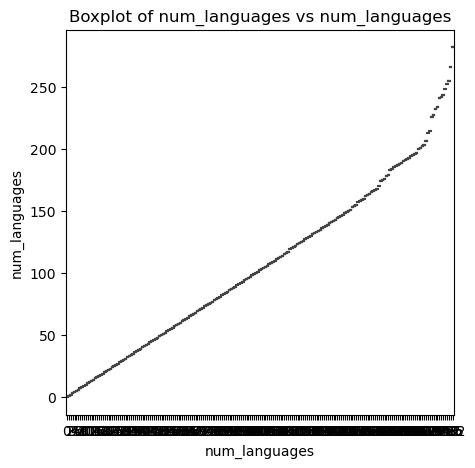

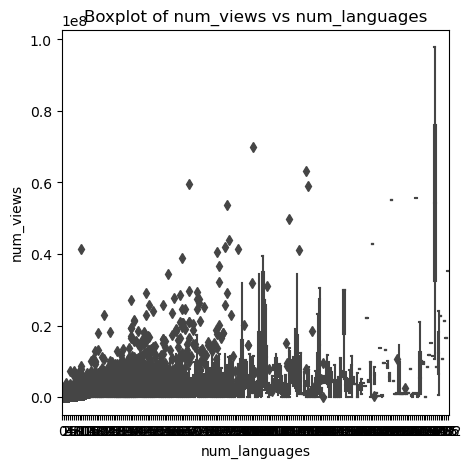

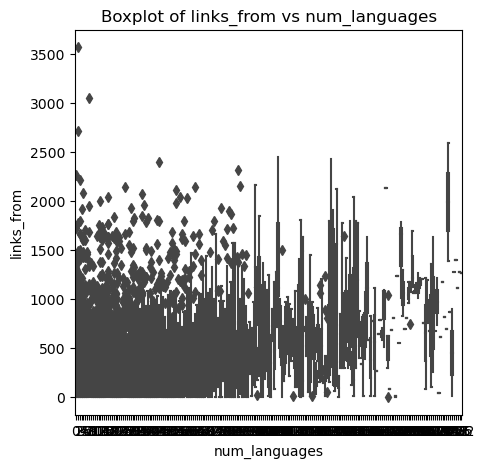

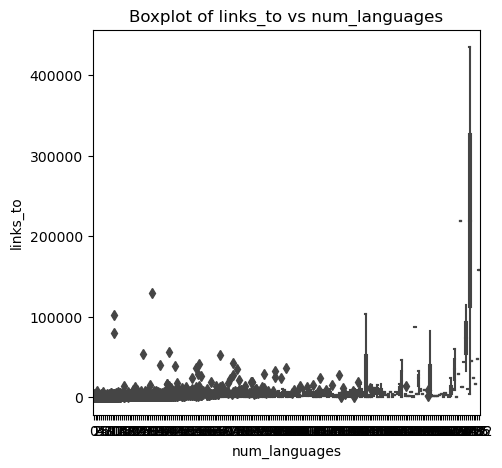

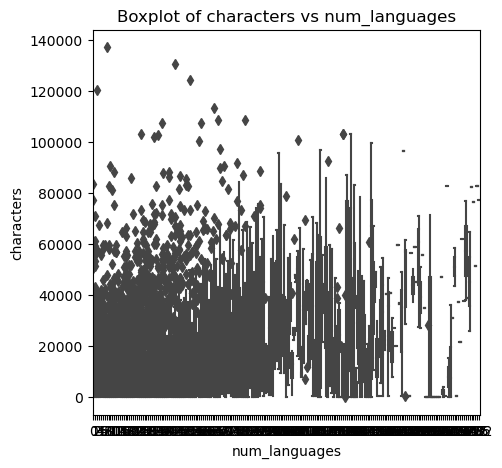

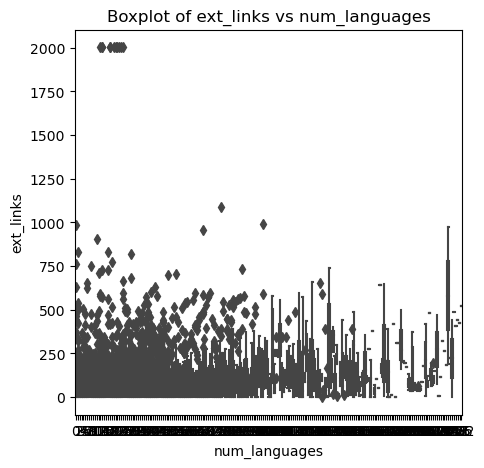

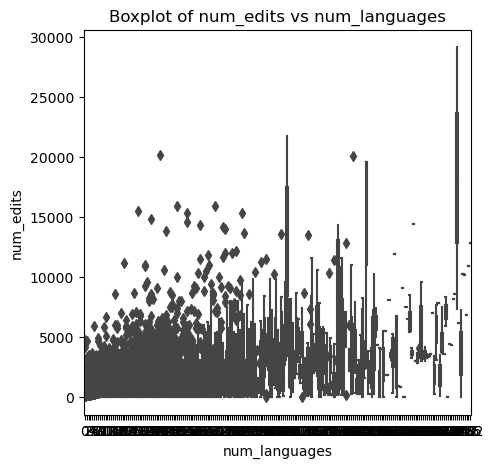

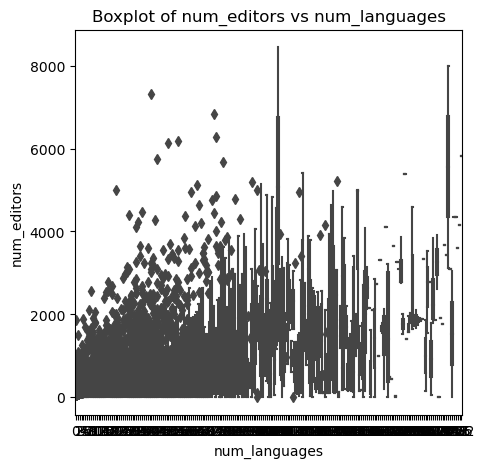

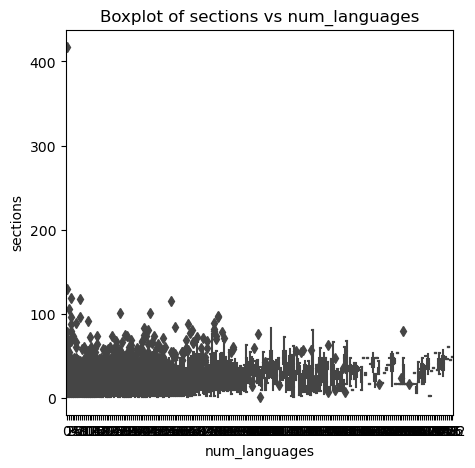

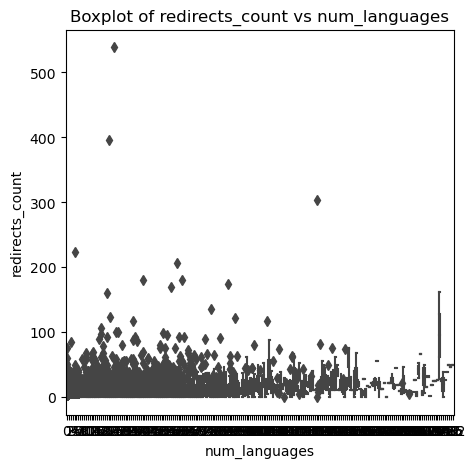

In [287]:
columns = ['num_languages', 'num_views', 'links_from', 'links_to','characters',
           'ext_links','num_edits','num_editors','sections','redirects_count' 
           ]
for column in columns:
    plt.figure(figsize=(5,5))
    sns.boxplot(x="num_languages", y=column, data=balanced_dataset)
    plt.title('Boxplot of ' + column + ' vs num_languages')
    plt.show()


<AxesSubplot:>

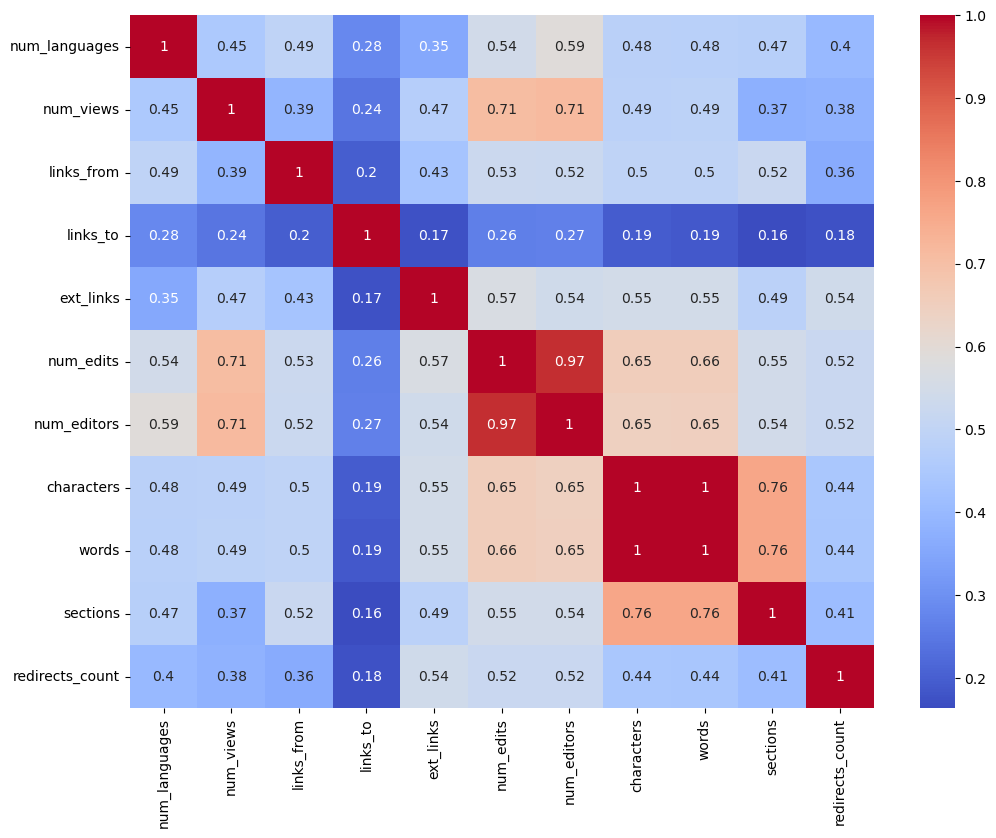

In [288]:
plt.figure(figsize=(12, 9))
sns.heatmap(balanced_dataset.corr(), annot=True, cmap='coolwarm')


In [289]:
balanced_data = MyDataSet.copy()
balanced_dataset = balanced_dataset.drop('words', axis=1)

In [290]:
import numpy as np

def log_transform(df):
    numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
    for feature in numerical_features:
        if df[feature].min() >= 0:
            df[feature] = np.log1p(df[feature])
    return df


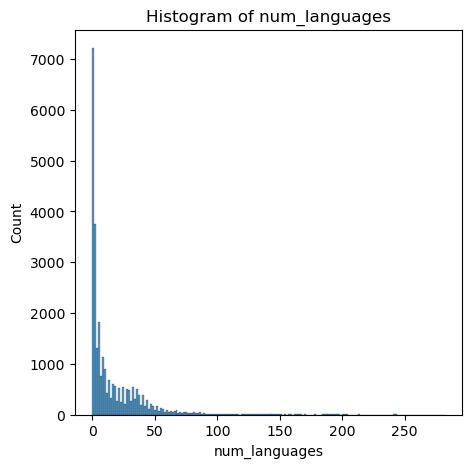

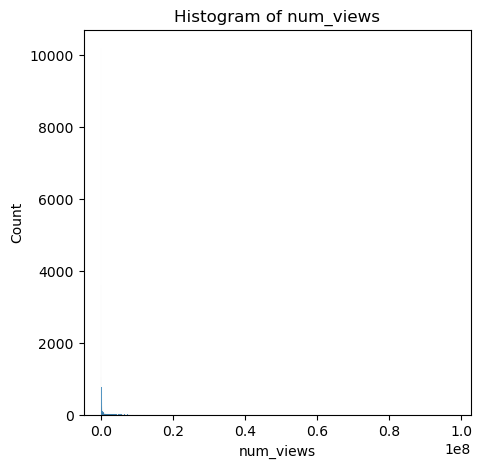

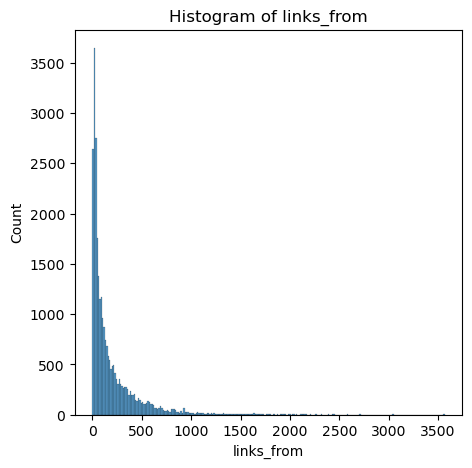

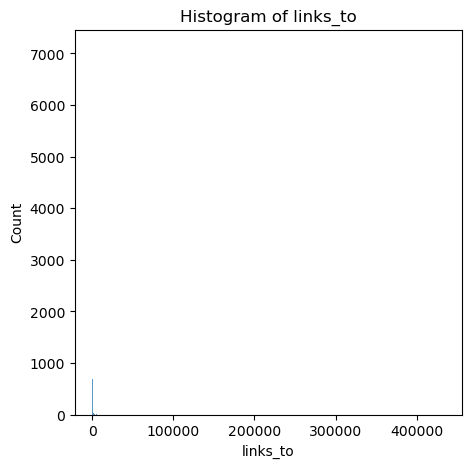

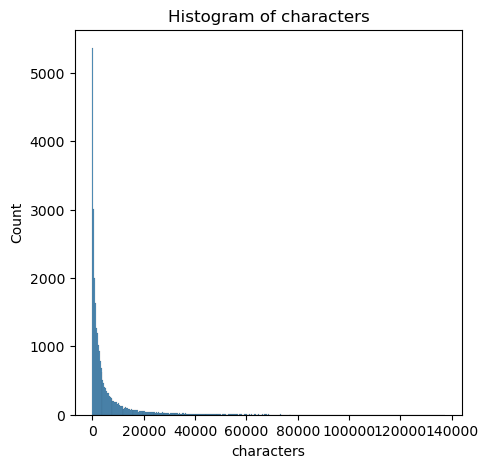

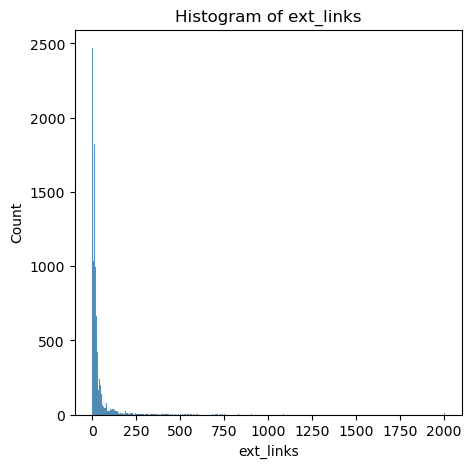

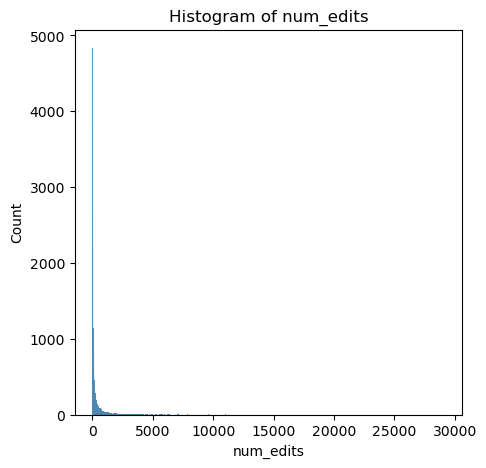

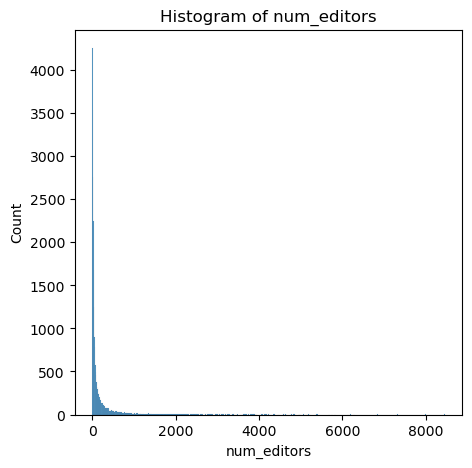

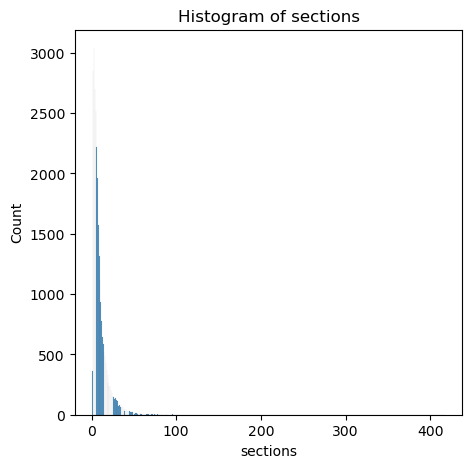

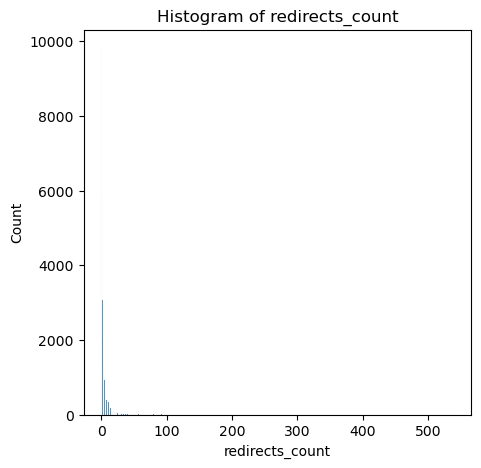

In [291]:
columns = ['num_languages', 'num_views', 'links_from', 'links_to','characters',
           'ext_links','num_edits','num_editors','sections','redirects_count' 
           ]

for column in columns:
    plt.figure(figsize=(5,5))
    sns.histplot(data=balanced_dataset, x=column)
    plt.title('Histogram of ' + column)
    plt.show()


In [292]:
transformed_df = balanced_dataset.copy()

transformed_df = log_transform(transformed_df)


In [293]:
transformed_df['num_languages'] = transformed_df['num_languages'].astype(int)

<AxesSubplot:>

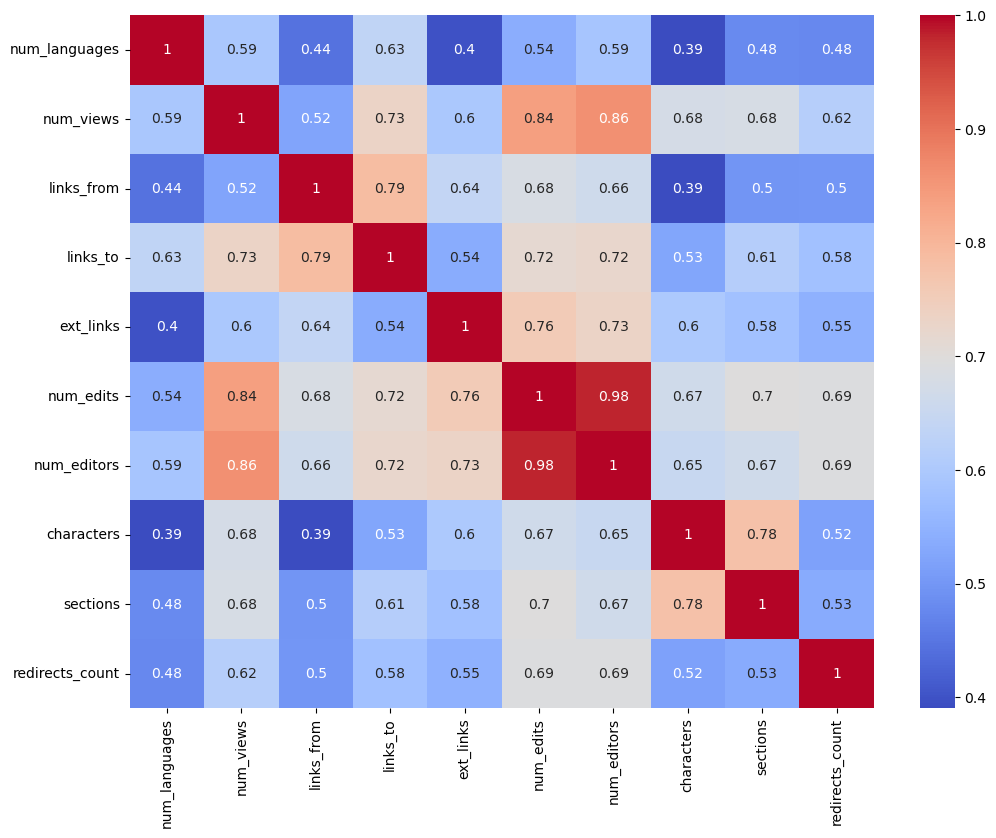

In [294]:
plt.figure(figsize=(12, 9))
sns.heatmap(transformed_df.corr(), annot=True, cmap='coolwarm')


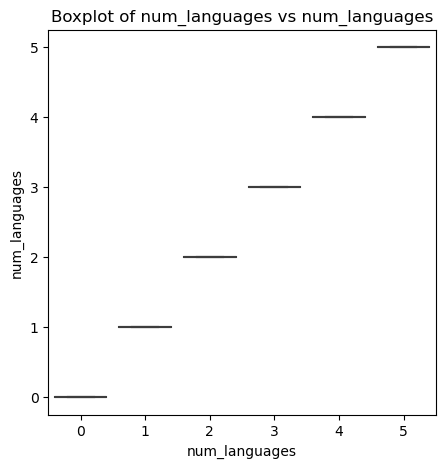

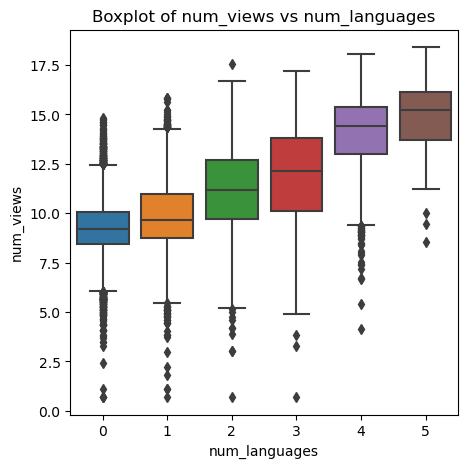

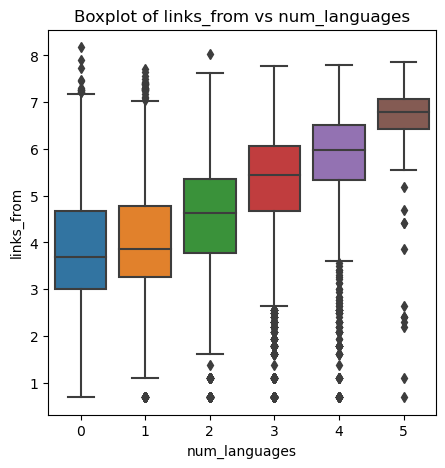

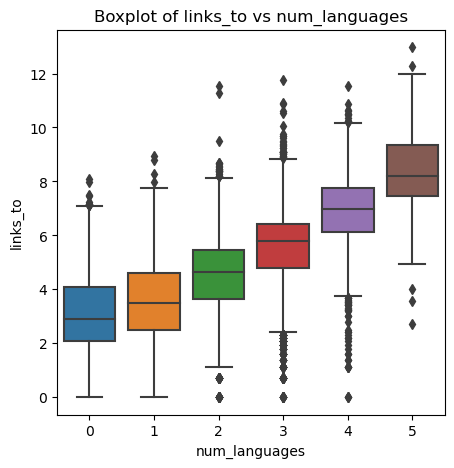

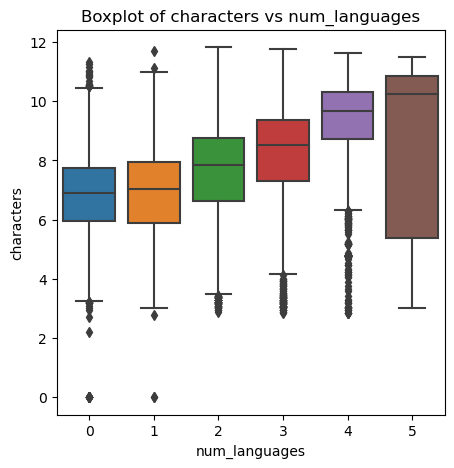

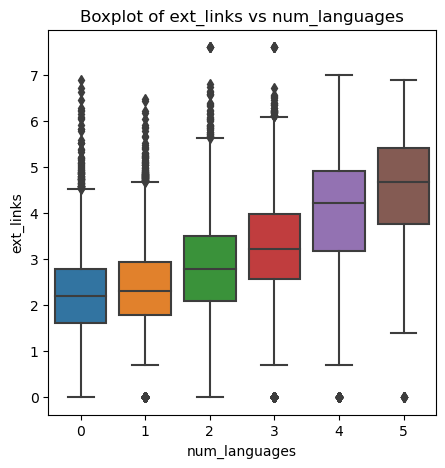

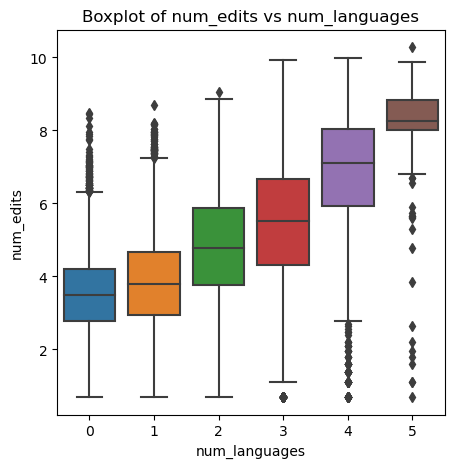

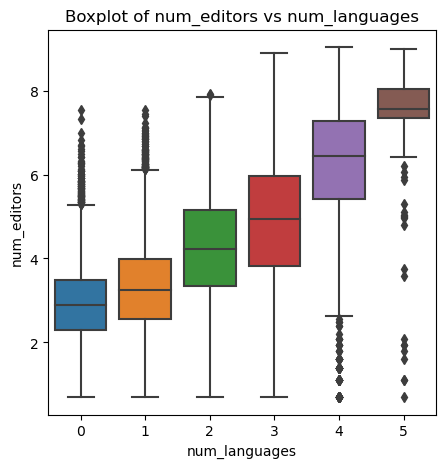

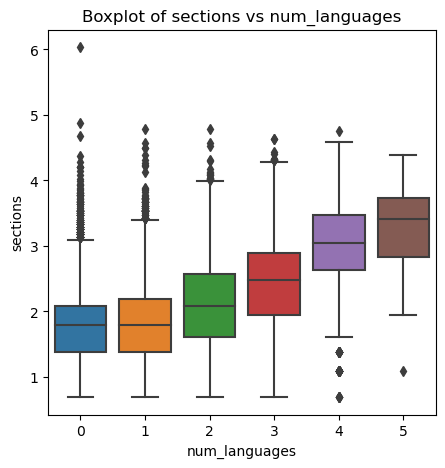

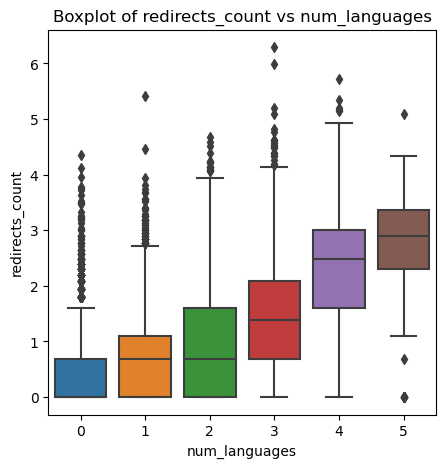

In [295]:
columns = ['num_languages', 'num_views', 'links_from', 'links_to','characters',
           'ext_links','num_edits','num_editors','sections','redirects_count' 
           ]

for column in columns:
    plt.figure(figsize=(5,5))
    sns.boxplot(x="num_languages", y=column, data=transformed_df)
    plt.title('Boxplot of ' + column + ' vs num_languages')
    plt.show()


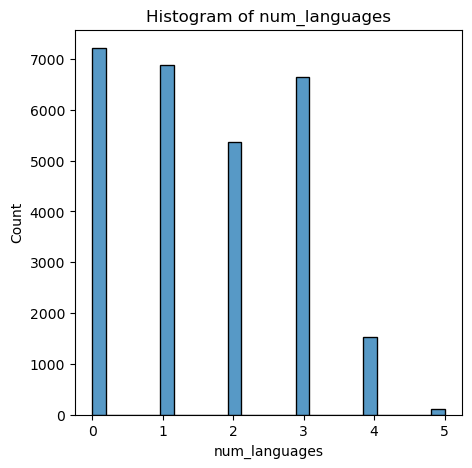

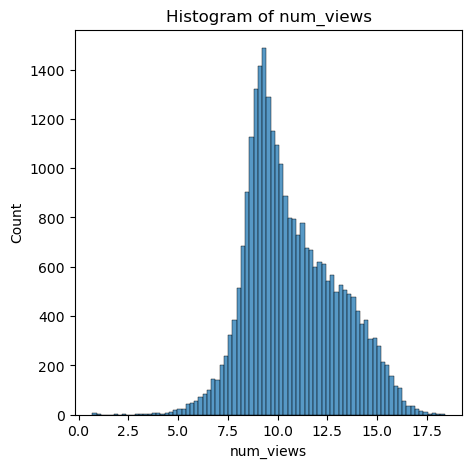

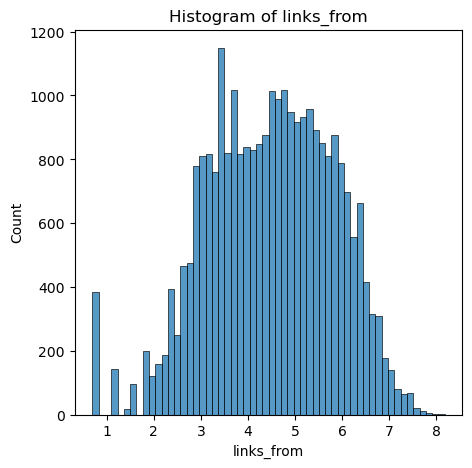

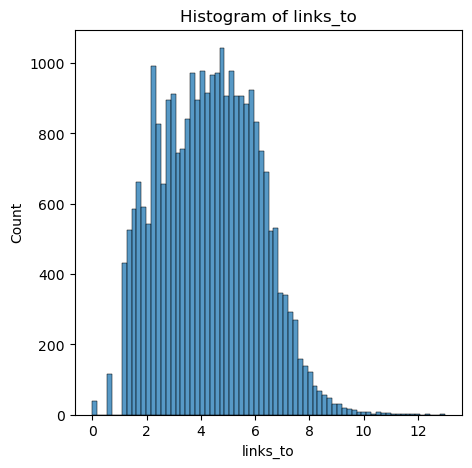

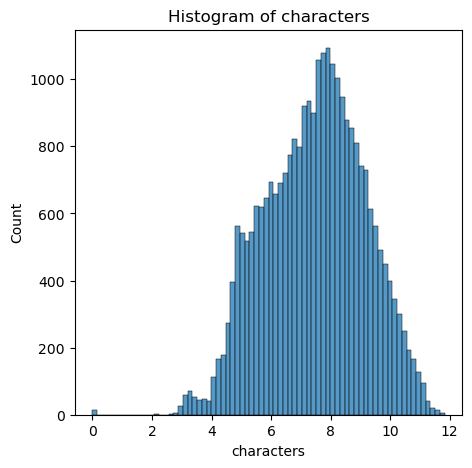

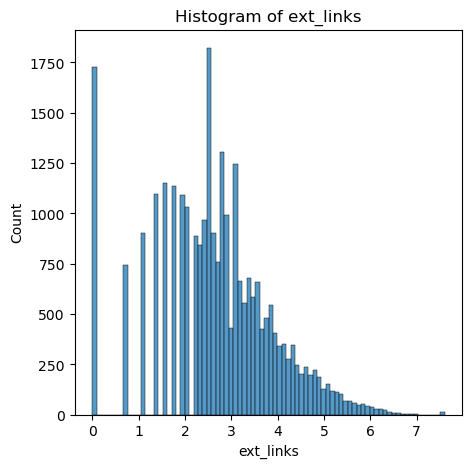

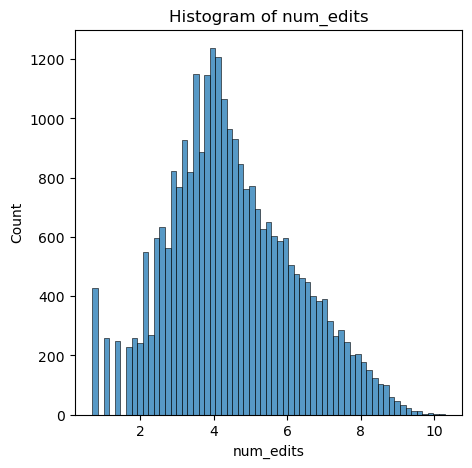

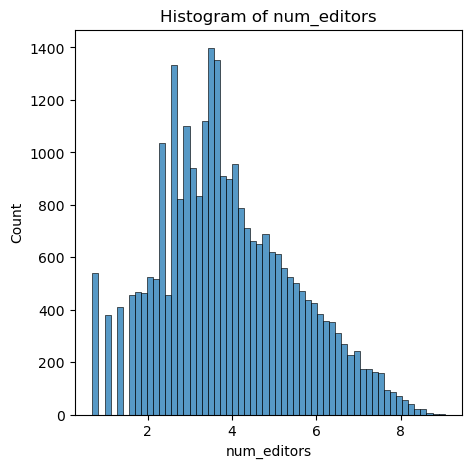

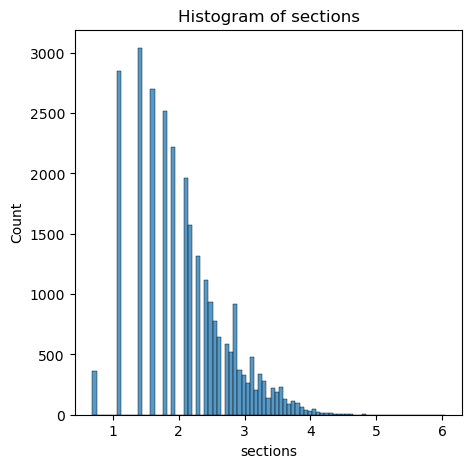

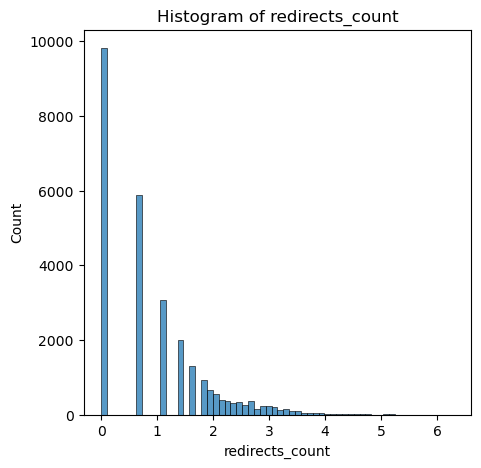

In [296]:
columns = ['num_languages', 'num_views', 'links_from', 'links_to','characters',
           'ext_links','num_edits','num_editors','sections','redirects_count' 
           ]

for column in columns:
    plt.figure(figsize=(5,5))
    sns.histplot(data=transformed_df, x=column)
    plt.title('Histogram of ' + column)
    plt.show()


In [297]:
perform_random_forest_classification(transformed_df, 'num_languages')
perform_naive_bayes_classification(transformed_df, 'num_languages')
perform_knn(transformed_df, 'num_languages')

Random Forest accuracy: 0.5442103367549073
Random Forest F1 score: 0.5314410613003692
Naive Bayes accuracy: 0.3828561138123537
Naive Bayes F1 score: 0.3600391787550234
knn Accuracy: 0.5211597334773996
knn F1 score: 0.5060487536669775


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [298]:
def perform_random_forest_classification_Matrix(dataset, target):

    X = dataset.drop([target, 'Topic'], axis=1)
    y = dataset[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print('Random Forest accuracy:', accuracy_score(y_test, y_pred))
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('Random Forest F1 score:', f1)

    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:\n', cm)

    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()

    return clf


In [299]:
transformed_df

,Topic,num_languages,num_views,links_from,links_to,ext_links,num_edits,num_editors,characters,sections,redirects_count
0,Albert Heijn,2,13.345120,5.831882,5.659482,3.367296,6.040255,5.605802,8.834483,2.639057,1.945910
1,Silver–cadmium battery,1,8.778326,4.442651,4.477337,0.000000,3.135494,2.564949,7.816820,1.386294,1.098612
2,Rádio Expres,1,9.981605,4.634729,4.997212,2.639057,3.761200,3.465736,6.888572,1.386294,0.693147
3,Prime Minister of Poland,3,13.267089,6.391917,7.009409,3.135494,6.214608,5.717028,10.059807,2.890372,2.484907
4,Mont-de-Marsan Agglomération,1,5.831882,3.583519,3.044522,2.484907,1.098612,1.098612,6.177944,1.386294,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
31121,Geoffrey Blake,1,8.927049,2.079442,2.564949,0.000000,2.708050,2.397895,3.433987,1.098612,1.098612
31122,Tasya Fantasya,0,10.406956,3.332205,3.135494,2.302585,5.549076,4.382027,7.142037,2.079442,0.693147
31123,Holland–Dozier–Holland,2,13.734077,5.817111,6.184149,3.367296,6.519147,5.723585,8.790117,2.564949,2.302585
31124,Stanley Cup playoffs,1,14.893757,5.926926,6.733402,3.850148,6.633318,5.802118,10.102707,2.890372,1.791759


Random Forest accuracy: 0.5442103367549073
Random Forest F1 score: 0.5314410613003692
Confusion matrix:
 [[ 975  336   71   48    0    0]
 [ 502  553  206  118    3    0]
 [ 141  255  361  337    9    0]
 [  22   52  173 1009   64    1]
 [   0    1   11  161  115    4]
 [   1    0    1    5    9    9]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


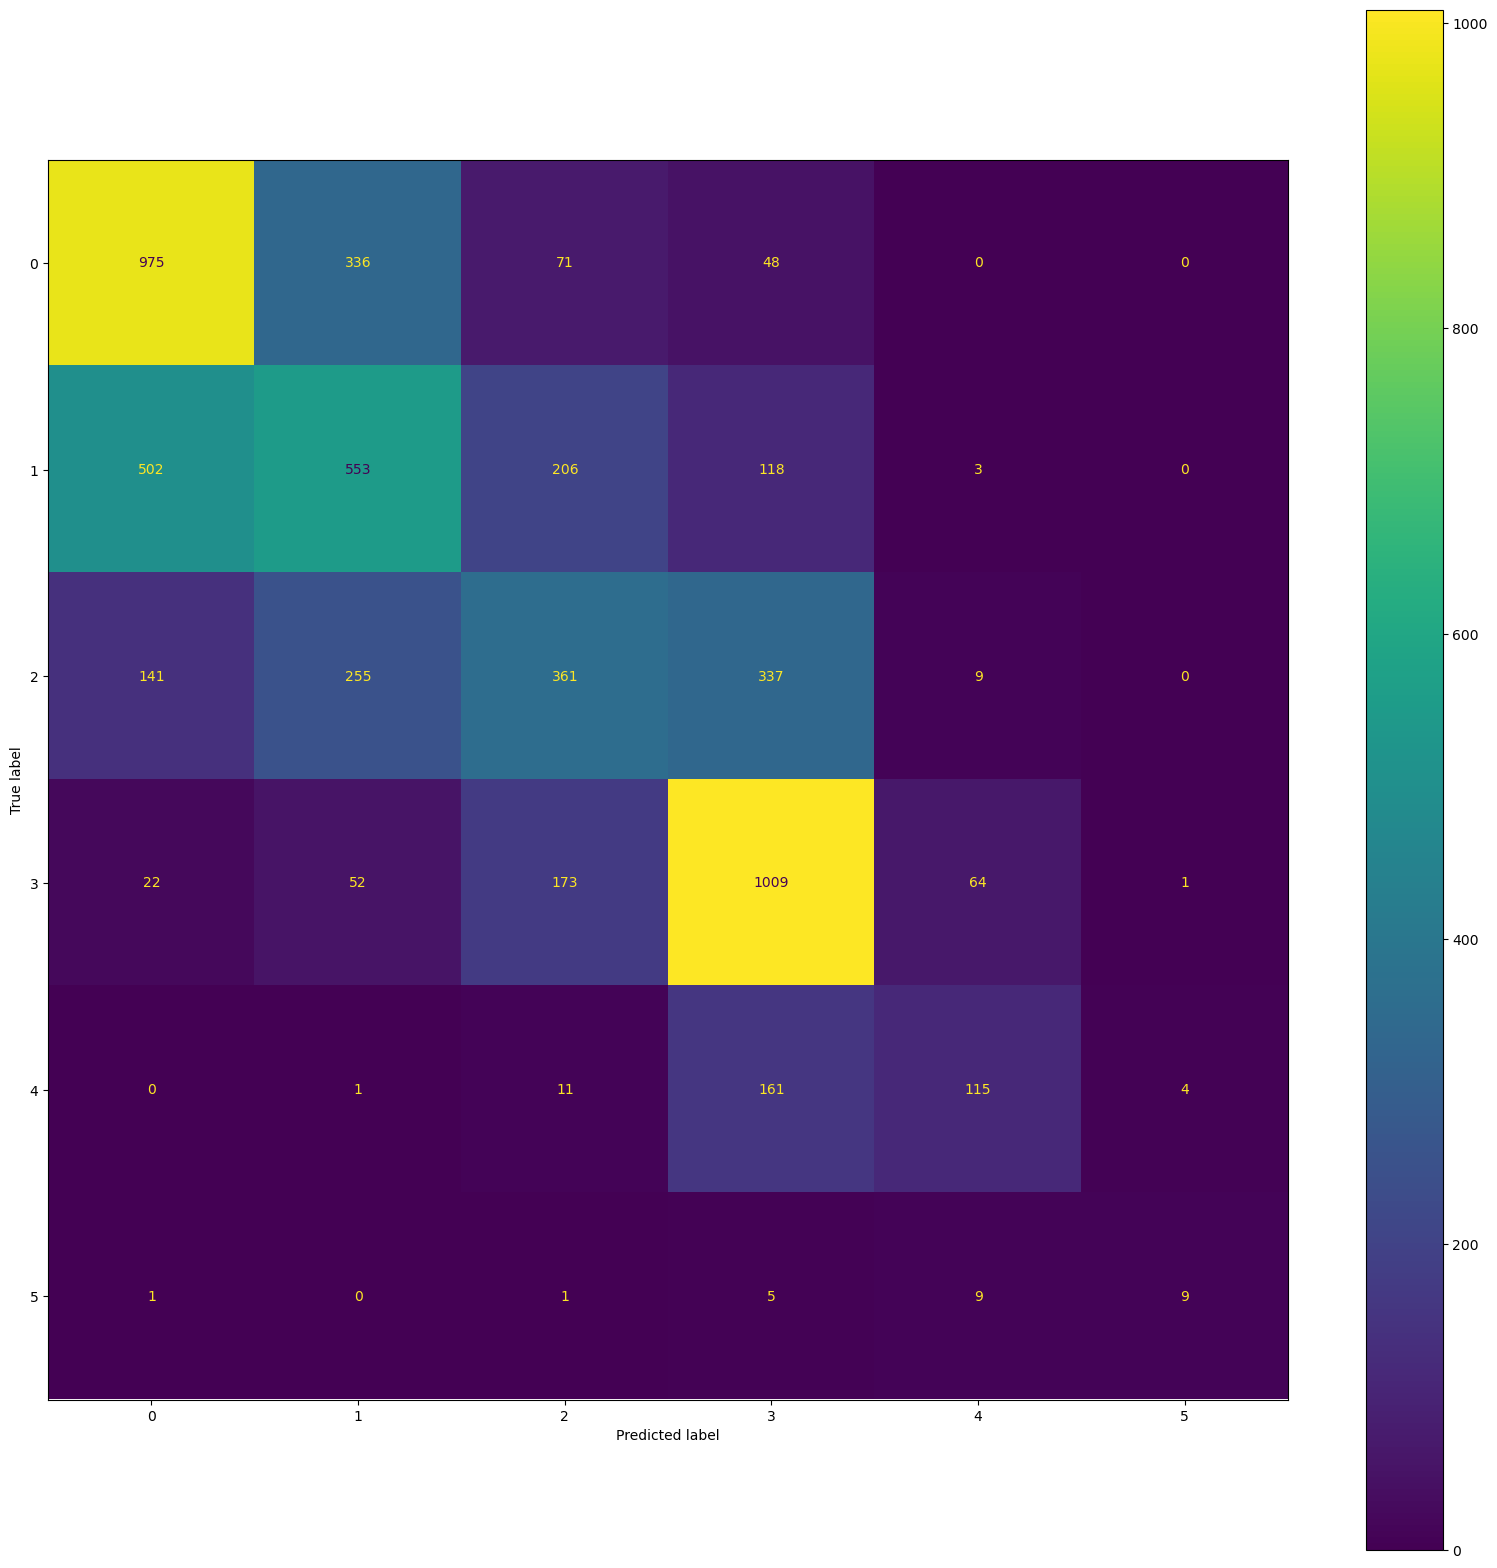

RandomForestClassifier(random_state=42)

In [300]:
perform_random_forest_classification_Matrix(transformed_df, 'num_languages')